## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
bs=256

### Look at data

In [13]:
!ls {PATH}train | head

0_frog.png
10000_automobile.png
10001_frog.png
10002_frog.png
10003_ship.png
10004_ship.png
10005_cat.png
10006_deer.png
10007_frog.png
10008_airplane.png
ls: write error: Broken pipe


In [14]:
def to_label_subdirs(path, subdirs, classes, labelfn):
    for sd in subdirs:
        for rf in os.listdir(os.path.join(path, sd)):
            af = os.path.join(path, sd, rf)
            if not os.path.isfile(af):
                continue
            lb = labelfn(rf)
            if lb is None or lb == '':
                continue
            os.renames(af, os.path.join(path, sd, lb, rf))

In [15]:
to_label_subdirs(PATH, 'train test'.split(), classes, lambda f: f[f.find('_')+1 : f.find('.')])

In [16]:
data = get_data(32,4)

In [17]:
x,y=next(iter(data.trn_dl))

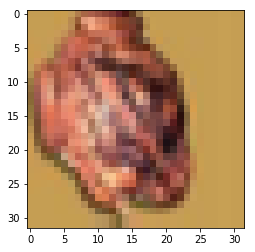

In [18]:
plt.imshow(data.trn_ds.denorm(x)[0]);

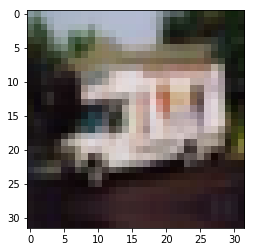

In [19]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [20]:
data = get_data(32,bs)

In [21]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [22]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [23]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [24]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [25]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [26]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 145/196 [00:06<00:02, 23.66it/s, loss=13.8]


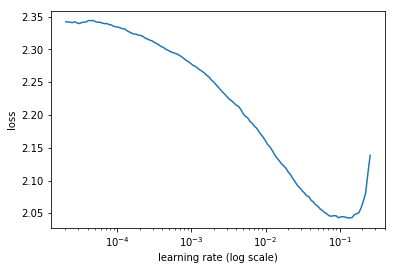

In [27]:
learn.sched.plot()

In [28]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.759009   1.621557   0.431152  
    1      1.678434   1.575282   0.44834   

CPU times: user 24.1 s, sys: 8.93 s, total: 33 s
Wall time: 16.6 s


[1.575282, 0.44833984375]

In [29]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.624582   1.518731   0.470801  
    1      1.606948   1.502146   0.478516  

CPU times: user 23.6 s, sys: 8.76 s, total: 32.4 s
Wall time: 16.3 s


[1.502146, 0.478515625]

## CNN

In [30]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [31]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [32]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [33]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 185/196 [00:07<00:00, 26.02it/s, loss=8.93]


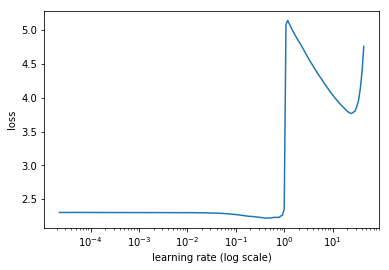

In [34]:
learn.sched.plot()

In [35]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.716972   1.628794   0.40332   
    1      1.53881    1.45944    0.471289  

CPU times: user 24.1 s, sys: 8.83 s, total: 32.9 s
Wall time: 16.6 s


[1.4594405, 0.4712890625]

In [36]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.344667   1.270522   0.54375   
    1      1.284739   1.209077   0.566309  
    2      1.237465   1.170855   0.572266  
    3      1.217285   1.146613   0.586914  

CPU times: user 48 s, sys: 17.5 s, total: 1min 5s
Wall time: 33 s


[1.1466131, 0.5869140625]

## Refactored

In [37]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [38]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [39]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [40]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [41]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.708241   1.565672   0.437598  
    1      1.533528   1.493888   0.459473  

CPU times: user 24.3 s, sys: 8.41 s, total: 32.7 s
Wall time: 16.5 s


[1.4938875, 0.45947265625]

In [42]:
%time learn.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.355856   1.273444   0.542188  
    1      1.296918   1.21095    0.56748   

CPU times: user 24.1 s, sys: 8.63 s, total: 32.7 s
Wall time: 16.5 s


[1.2109505, 0.56748046875]

## BatchNorm

In [43]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [44]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [45]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [46]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [47]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.507094   1.355463   0.501953  
    1      1.281697   1.199078   0.565039  

CPU times: user 26.3 s, sys: 8.83 s, total: 35.1 s
Wall time: 17.5 s


[1.1990783, 0.5650390625]

In [48]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.207218   1.077457   0.619043  
    1      1.08516    0.983779   0.654395  
    2      0.987676   0.886224   0.68584   
    3      0.922969   0.86164    0.698145  

CPU times: user 52.2 s, sys: 17.9 s, total: 1min 10s
Wall time: 34.9 s


[0.86164033, 0.69814453125]

## Deep BatchNorm

In [49]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [52]:
learn = ConvLearner.from_model_data((ConvBnNet2([10, 20, 40, 80, 160], 10)), data)

In [53]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.511143   1.392558   0.493945  
    1      1.284835   1.201425   0.562695  

CPU times: user 28.5 s, sys: 9.07 s, total: 37.6 s
Wall time: 19.2 s


[1.2014248, 0.5626953125]

In [54]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.107834   1.041597   0.625098  
    1      1.029534   0.97074    0.651074  

CPU times: user 28 s, sys: 9.47 s, total: 37.5 s
Wall time: 19.2 s


[0.97074014, 0.65107421875]

## Resnet

In [55]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [56]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [57]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [58]:
wd=1e-5

In [59]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.52868    1.319277   0.523926  
    1      1.284186   1.15814    0.581738  

CPU times: user 30.5 s, sys: 9.65 s, total: 40.1 s
Wall time: 22 s


[1.1581402, 0.58173828125]

In [60]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.068783   1.005272   0.63623   
    1      1.042962   0.958452   0.665137  
    2      0.913284   0.873534   0.693652  
    3      0.947505   0.887667   0.686035  
    4      0.838674   0.777359   0.728809  
    5      0.757651   0.749222   0.740625  
    6      0.701355   0.712478   0.746484  

CPU times: user 1min 46s, sys: 34.2 s, total: 2min 20s
Wall time: 1min 16s


[0.7124783, 0.746484375]

In [61]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.801826   0.767502   0.733691  
    1      0.729776   0.741393   0.74209   
    2      0.651035   0.667219   0.769629  
    3      0.620044   0.652672   0.771484  
    4      0.702187   0.730261   0.749609  
    5      0.653944   0.661661   0.774805  
    6      0.573436   0.604932   0.790137  
    7      0.536271   0.610769   0.787109  
    8      0.640723   0.679299   0.772461  
    9      0.590981   0.627143   0.784668  
    10     0.52322    0.593358   0.794727  
    11     0.476234   0.579521   0.802539  
    12     0.594679   0.631863   0.786914  
    13     0.539236   0.617486   0.789355  
    14     0.478933   0.625881   0.787988  
    15     0.443329   0.542087   0.814258  
    16     0.545019   0.601006   0.79502   
    17     0.495451   0.552021   0.814551  
    18     0.436588   0.551621   0.811328  
    19     0.401233   0.550759   0.814746  
    20     0.516255   0.634121   0.786719  
    21     0.464605   0.549916 

[0.5645998, 0.82216796875]

## Resnet 2

In [62]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [63]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [64]:
wd=1e-6

In [65]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.728232   1.430878   0.484766  
    1      1.445593   1.286057   0.541602  

CPU times: user 31.7 s, sys: 10.4 s, total: 42.1 s
Wall time: 23.9 s


[1.2860569, 0.5416015625]

In [66]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.208481   1.113554   0.605469  
    1      1.158585   1.128595   0.602539  
    2      1.000622   0.949971   0.665527  
    3      1.071111   0.986917   0.65      
    4      0.951904   0.907905   0.683984  
    5      0.842165   0.806152   0.716211  
    6      0.796563   0.793129   0.716602  

CPU times: user 1min 51s, sys: 35.4 s, total: 2min 26s
Wall time: 1min 22s


[0.7931288, 0.7166015625]

In [67]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.93342    1.069273   0.643652  
    1      0.820791   0.773493   0.731348  
    2      0.714066   0.738694   0.744434  
    3      0.672453   0.742333   0.743555  
    4      0.788699   0.774578   0.72959   
    5      0.708566   0.676906   0.7625    
    6      0.629311   0.657188   0.769336  
    7      0.583782   0.623351   0.784863  
    8      0.713689   0.796423   0.736523  
    9      0.638235   0.646267   0.775977  
    10     0.56532    0.586408   0.797656  
    11     0.520528   0.576753   0.8       
    12     0.653233   0.689408   0.763867  
    13     0.582897   0.60589    0.792871  
    14     0.507893   0.550775   0.809082  
    15     0.475197   0.570207   0.803125  
    16     0.591783   0.675813   0.775     
    17     0.531013   0.559095   0.805273  
    18     0.456376   0.566962   0.808398  
    19     0.42531    0.55726    0.810938  
    20     0.54286    0.625062   0.795312  
    21     0.485906   0.552662 

[0.5486104, 0.82607421875]

In [68]:
learn.save('tmp3')

In [69]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [71]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.4642062529126156, 0.8416)

### End